Matplotlib is building the font cache; this may take a moment.


MAE (Decision Tree): 24.24
RMSE (Decision Tree): 33.25


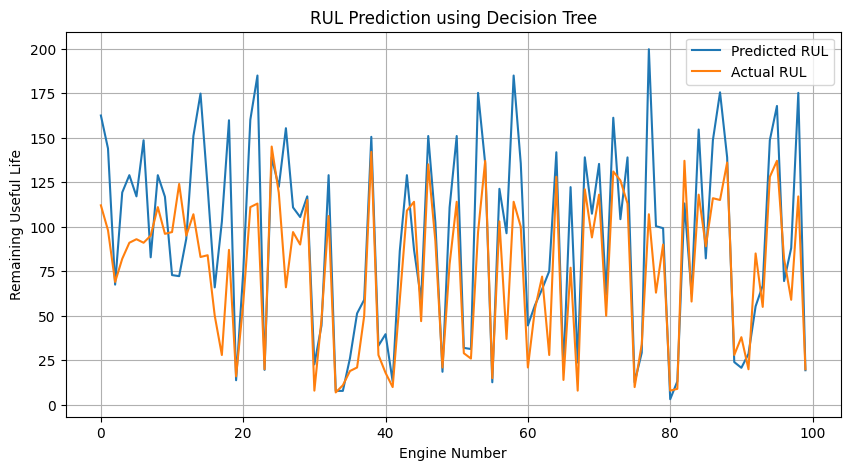

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------
# STEP 1: Load and Preprocess Data
# ----------------------------

# Load datasets
train = pd.read_csv('./data/train_FD001.txt', sep=' ', header=None)
test = pd.read_csv('./data/test_FD001.txt', sep=' ', header=None)
rul = pd.read_csv('./data/RUL_FD001.txt', sep=' ', header=None)

# Drop empty columns
train.drop(train.columns[[26, 27]], axis=1, inplace=True)
test.drop(test.columns[[26, 27]], axis=1, inplace=True)

# Assign column names
cols = ['unit', 'time'] + [f'op{i}' for i in range(1, 4)] + [f'sensor{i}' for i in range(1, 22)]
train.columns = test.columns = cols

# Add RUL to train data
rul_train = train.groupby('unit')['time'].max().reset_index()
rul_train.columns = ['unit', 'max_time']
train = train.merge(rul_train, on='unit')
train['RUL'] = train['max_time'] - train['time']
train.drop('max_time', axis=1, inplace=True)

# ----------------------------
# STEP 2: Feature Selection
# ----------------------------

# Remove constant or uninformative sensors
drop_cols = ['unit', 'time', 'RUL'] + [f'sensor{i}' for i in [1, 5, 6, 10, 16, 18, 19]]
features = [col for col in train.columns if col not in drop_cols]
X_train = train[features]
y_train = train['RUL']

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# ----------------------------
# STEP 3: Train Decision Tree
# ----------------------------

dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train_scaled, y_train)

# ----------------------------
# STEP 4: Prepare Test Data
# ----------------------------

# Use the last cycle of each engine for prediction
X_test = test.groupby('unit').last().reset_index()
X_test = X_test[features]
X_test_scaled = scaler.transform(X_test)

# Predict RUL
predicted_rul = dt_model.predict(X_test_scaled)

# Actual RUL values
actual_rul = pd.read_csv("./data/RUL_FD001.txt", header=None)
actual_rul.columns = ['RUL']

# ----------------------------
# STEP 5: Evaluation
# ----------------------------

mae = mean_absolute_error(actual_rul, predicted_rul)
rmse = np.sqrt(mean_squared_error(actual_rul, predicted_rul))

print(f"MAE (Decision Tree): {mae:.2f}")
print(f"RMSE (Decision Tree): {rmse:.2f}")

# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(predicted_rul, label='Predicted RUL')
plt.plot(actual_rul.values, label='Actual RUL')
plt.legend()
plt.title("RUL Prediction using Decision Tree")
plt.xlabel("Engine Number")
plt.ylabel("Remaining Useful Life")
plt.grid(True)
plt.show()